In [ ]:
!pip3 install numpy==1.22.1 matplotlib==3.8 opencv-python gtsam tqdm open3d

In [ ]:
!pip install typeguard

In [117]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import gtsam
import glob
import open3d as o3d
from tqdm import tqdm

In [118]:
# # KITTI
# fx, fy = 718.856, 718.856
# cx, cy = 607.1928, 185.2157

# TUM
fx, fy, cx, cy = 0.535719308086809 * 1280,	0.669566858850269 * 1024,	0.493248545285398 * 1280,	0.500408664348414 * 1024
omega = 0.897966326944875

K = np.array([[fx, 0, cx],
              [0, fy, cy],
              [0,  0,  1]], dtype=np.float64)

In [119]:
# --- Parameters ---
# images_path = "../dataset/images/04/image_0/*.png"
# images_path = "../dataset/images/17/*.png"
images_path = "../dataset/images/TUM/sequence_49/images_downsampled/*.jpg"
min_features = 2000

FIRST_FRAME = 180
N_FRAMES = 100

# --- Load and sort images ---
image_files = sorted(glob.glob(images_path))[FIRST_FRAME:FIRST_FRAME+N_FRAMES]
if not image_files:
    raise RuntimeError("No images found in folder!")
print(f"Images loaded: {len(image_files)}")

# --- Initialize FAST detector ---
fast = cv2.FastFeatureDetector_create(threshold=25, nonmaxSuppression=True)

Images loaded: 100


In [120]:
def undistort_points_fov(points_2d, K, omega, cutoff_fov_deg=170):
    if len(points_2d) == 0:
        return np.array([]), np.array([])

    points_2d = points_2d.reshape(-1, 2)

    # center the coordinates in the principal point and normalize them
    fx, fy = K[0, 0], K[1, 1]
    cx, cy = K[0, 2], K[1, 2]
    
    x_dist = (points_2d[:, 0] - cx) / fx
    y_dist = (points_2d[:, 1] - cy) / fy
    
    # compute the radial distance from the center ("radius distorted")
    r_dist = np.sqrt(x_dist**2 + y_dist**2)

    '''
    I want to compute the maximum valid radius because:
    Normally to find the distance of a pixel from the center I would compute 
    
    r_undistorted = f * tan(theta)
    
    where theta is the incoming light ray angle.
    However we are using a fisheye lens (FOV model https://github.com/JakobEngel/dso#31-dataset-format:~:text=FOV%20fx%20fy%20cx%20cy%20omega) therefore we need to use the omega param to undistort it.
    
    r_distorted = theta / omega ---> theta = omega * r_distorted
    
    Now we can go back to the original formula and compute r_undistorted (we already normalized on f)
    
    r_undistorted = tan(r_distorted * omega)
    
    the undistorion formula has tan(r * omega) therefore if (r * omega) == PI / 2 we get infinity -> problem
    this is why we define a max value that (r * omega) can be without fucking up the model
    
    we also add an additional normalizing factor at the denominator to avoid changing the size of the image when we reproject back to pixel coordinates
    '''
    
    max_r_dist_omega = (np.pi / 2.0) * (cutoff_fov_deg / 180.0) # cutoff_fov_deg is arbitrary but should be < 180
    
    # keep only the points where (r_dist * omega) is safe 
    # OSS: r_dist is a np.array so valid_mask is a np.array as well
    valid_mask = (r_dist * np.abs(omega)) < max_r_dist_omega
    
    # if for some reason I don't have valid points return
    if not np.any(valid_mask):
         return np.array([]), valid_mask

    # apply distorion model
    # r_u = tan(r_d * omega) / (2 * tan(omega / 2))
    if abs(omega) > 1e-6:
        r_d_valid = r_dist
        r_u_valid = np.tan(r_d_valid * omega) / (2 * np.tan(omega / 2.0))
        
        # Scaling factor
        with np.errstate(divide='ignore', invalid='ignore'):
            scale = r_u_valid / r_d_valid
            scale[r_d_valid < 1e-7] = 1.0
            
        x_dist = x_dist * scale
        y_dist = y_dist * scale
    
    else: # if omega is very very small we can just ignore the distortion
        pass

    # we go back to original pixel coordinates
    x_final = x_dist * fx + cx
    y_final = y_dist * fy + cy
    
    undistorted_valid = np.stack((x_final, y_final), axis=1)
    
    return undistorted_valid[valid_mask], valid_mask # I choose to return only valid points

In [121]:
def detect_new_features(img, existing_ids):
    global next_feature_id
    keypoints = fast.detect(img, None)
    new_pts = []
    new_ids = []
    for kp in keypoints:
        x, y = kp.pt
        new_pts.append([x, y])
        new_ids.append(next_feature_id)
        next_feature_id += 1
    points_raw = np.array(new_pts, dtype=np.float32).reshape(-1, 1, 2)
    
    return points_raw, new_ids

In [122]:
# --- Tracking state ---
next_feature_id = 0  # unique ID counter
tracked_points = {}  # {id: (x,y)}
tracks_per_frame = []  # list of dicts: [{id: (x,y)}, ...]

# --- First frame ---
prev_img = cv2.imread(image_files[0], cv2.IMREAD_GRAYSCALE)
prev_pts, prev_ids = detect_new_features(prev_img, set())

tracks_per_frame.append({pid: tuple(pt.ravel()) for pid, pt in zip(prev_ids, prev_pts)}) # first image

# --- Process frames ---
for fname in tqdm(image_files[1:N_FRAMES]): # iterate over all remaining frames
    frame = cv2.imread(fname, cv2.IMREAD_GRAYSCALE)

    # Track previous points with optical flow
    next_pts, status, _ = cv2.calcOpticalFlowPyrLK(prev_img, frame, prev_pts, None)
    status = status.flatten()

    # Keep only successfully tracked points
    good_new = next_pts[status == 1]
    good_old = prev_pts[status == 1]
    good_ids = [pid for pid, st in zip(prev_ids, status) if st == 1]

    # Update positions
    for pid, pt in zip(good_ids, good_new):
        tracked_points[pid] = pt

    # If features drop below threshold, add new ones
    if  len(good_new) < min_features:
        new_pts, new_ids = detect_new_features(frame, set(good_ids))
        good_new = np.vstack([good_new.reshape(-1, 1, 2), new_pts])
        good_ids.extend(new_ids)
    

    # Store current frame's tracks
    tracks_per_frame.append({pid: pt.ravel() for pid, pt in zip(good_ids, good_new)})

    # Update for next frame
    prev_img = frame
    prev_pts = good_new.reshape(-1, 1, 2)
    prev_ids = good_ids


100%|██████████| 99/99 [00:01<00:00, 81.20it/s]


In [123]:
'''
Right after I tracked all the points I undistort them all in one go
'''

def batch_undistort_tracks(tracks_raw, K, omega):
    tracks_clean = []
    print("Batch undistorting all tracks...")
    
    for frame_tracks in tqdm(tracks_raw):
        if not frame_tracks:
            tracks_clean.append({})
            continue
            
        # Extract IDs and Points
        ids = list(frame_tracks.keys())
        # Shape needs to be (N, 1, 2) for the undistort function logic usually, 
        # but your function handles reshaping. Let's pass (N, 2).
        pts_raw_np = np.array(list(frame_tracks.values()), dtype=np.float64)
        
        # Undistort
        # Your function returns: (points_valid, mask_boolean)
        pts_undist, mask = undistort_points_fov(pts_raw_np, K, omega)
        
        # Re-pack into dictionary, keeping only valid points
        # mask is boolean array matching the input order
        clean_frame = {}
        
        # We iterate through the mask to match IDs to the surviving points
        # pts_undist contains only the survivors, so we need a separate counter for it
        survivor_idx = 0
        for i, is_valid in enumerate(mask):
            if is_valid:
                pid = ids[i]
                clean_frame[pid] = pts_undist[survivor_idx]
                survivor_idx += 1
                
        tracks_clean.append(clean_frame)
        
    return tracks_clean

# --- EXECUTE BATCH UNDISTORTION ---
tracks_per_frame = batch_undistort_tracks(tracks_per_frame, K, omega)

Batch undistorting all tracks...


100%|██████████| 100/100 [00:00<00:00, 853.69it/s]


In [124]:
def compute_essential(tracks_per_frame, i, j, K):
    # Get correspondences by ID
    ids_i = set(tracks_per_frame[i].keys())
    ids_j = set(tracks_per_frame[j].keys())
    common_ids = list(ids_i & ids_j)  # intersection

    if len(common_ids) < 5:
        raise ValueError("Not enough matches to compute Essential matrix")

    pts1 = np.array([tracks_per_frame[i][pid] for pid in common_ids], dtype=np.float32)
    pts2 = np.array([tracks_per_frame[j][pid] for pid in common_ids], dtype=np.float32)

    # Compute essential matrix
    E, inliers = cv2.findEssentialMat(pts1, pts2, K, method=cv2.RANSAC, prob=0.999, threshold=1.0)

    return E, inliers, pts1, pts2, np.array(common_ids)

In [125]:
def get_3D_points(tracks, prev_frame_id, curr_frame_id, K, prev_R, prev_t, curr_R, curr_t, existing_ids, min_depth=0.5, max_depth=40.0):
    # Note: 'tracks' argument must now be the undistorted list!
    
    pts_prev_dict = tracks[prev_frame_id]
    pts_curr_dict = tracks[curr_frame_id]
    
    common_ids = list(pts_prev_dict.keys() & pts_curr_dict.keys())
    
    if existing_ids is not None:
        existing_set = set(existing_ids)
        common_ids = [i for i in common_ids if i not in existing_set]

    if len(common_ids) < 2:
        return None, None, np.array([]), np.array([])

    # Points are already undistorted!
    pts1 = np.array([pts_prev_dict[i] for i in common_ids], dtype=np.float64)
    pts2 = np.array([pts_curr_dict[i] for i in common_ids], dtype=np.float64)

    # Standard Linear Triangulation
    P1 = K @ np.hstack([prev_R, prev_t.reshape(3,1)]) 
    P2 = K @ np.hstack([curr_R, curr_t.reshape(3,1)])
    
    points_4d = cv2.triangulatePoints(P1, P2, pts1.T, pts2.T)
    points_3d = (points_4d[:3] / points_4d[3]).T

    # Depth Filter
    points_cam = (curr_R @ points_3d.T + curr_t.reshape(3,1)).T
    depths = points_cam[:, 2]
    depth_mask = (depths > min_depth) & (depths < max_depth)
    
    return None, None, np.array(common_ids)[depth_mask], points_3d[depth_mask]

In [126]:
# # We compute the essential matrix for the first two frames
# E, inliers, pts1, pts2, common_ids = compute_essential(tracks_per_frame, 0, 1, K)
# print(f"Common points used: {len(common_ids)}")
# print(f"E:\n{E}")

# pts1 = np.asarray(pts1, dtype=np.float64).reshape(-1, 2)
# pts2 = np.asarray(pts2, dtype=np.float64).reshape(-1, 2)
# num_inliers, R1, t1, mask = cv2.recoverPose(E, pts1, pts2, K)

# print(f"c1_R_w:\n{R1}")
# print(f"c1_t_w:\n{t1}")

In [127]:
# # Projection matrices
# P1 = K @ np.hstack([np.eye(3), np.zeros((3, 1))]) # R0 ant t0 are respectively [I], [0,0,0]
# P2 = K @ np.hstack([R1, t1])

# # Select only inlier correspondences
# inlier_mask = mask.ravel().astype(bool)
# pts1_inl = pts1[inlier_mask]
# pts2_inl = pts2[inlier_mask]
# common_ids_inl = common_ids[inlier_mask]
# print(f"Inliers: {len(common_ids_inl)}")

# # Triangulate
# points_h = cv2.triangulatePoints(P1, P2, pts1_inl.T, pts2_inl.T)

# # Convert from homogeneous to 3D
# points_3d_ids = common_ids_inl
# points_3d = (points_h[:3] / points_h[3]).T # normalize bc they are homogeneous coordinates

In [128]:
# Cell 109

# Since we ran batch_undistort_tracks in Cell 104, 
# tracks_per_frame[0] and [1] are ALREADY undistorted.
# We can use them directly.

pts0_dict = tracks_per_frame[0]
pts1_dict = tracks_per_frame[1]

# 1. Find common IDs between the two frames
common_ids = list(pts0_dict.keys() & pts1_dict.keys())

# 2. Extract the points directly (They are already clean!)
pts0_clean = np.array([pts0_dict[i] for i in common_ids], dtype=np.float64)
pts1_clean = np.array([pts1_dict[i] for i in common_ids], dtype=np.float64)
common_ids = np.array(common_ids)

# 3. Compute Essential Matrix and Pose
# Note: We use the same K because undistort_points_fov attempts to 
# map points back to the original K pinhole model.
E, mask_e = cv2.findEssentialMat(pts0_clean, pts1_clean, K, method=cv2.RANSAC, prob=0.999, threshold=1.0)
_, R1, t1, mask_rp = cv2.recoverPose(E, pts0_clean, pts1_clean, K, mask=mask_e)

print(f"Initial Pose R:\n{R1}")
print(f"Initial Pose t:\n{t1}")

# 4. Triangulate Initial Points
P1 = K @ np.hstack([np.eye(3), np.zeros((3, 1))])
P2 = K @ np.hstack([R1, t1])

mask_rp = mask_rp.ravel().astype(bool)
pts0_tri = pts0_clean[mask_rp]
pts1_tri = pts1_clean[mask_rp]
ids_tri = common_ids[mask_rp]

points_4d = cv2.triangulatePoints(P1, P2, pts0_tri.T, pts1_tri.T)
points_3d_init = (points_4d[:3] / points_4d[3]).T

# 5. Filter based on depth
pts_cam2 = (R1 @ points_3d_init.T + t1).T
depths = pts_cam2[:, 2]
depth_mask = (depths > 0.5) & (depths < 40.0)

points_3d = points_3d_init[depth_mask]
points_3d_ids = ids_tri[depth_mask]

print(f"Initialized Map with {len(points_3d)} points.")

Initial Pose R:
[[ 0.99751888  0.06922556  0.01280277]
 [-0.06984608  0.99593213  0.05692736]
 [-0.00880986 -0.05768034  0.99829623]]
Initial Pose t:
[[-0.66367344]
 [ 0.05941432]
 [-0.74565911]]
Initialized Map with 457 points.


In [129]:
'''
PnP is the problem of estimating the pose of a calibrated camera given a set of n 3D points in the world
and their corresponding 2D projections in the image. Since I need to undistort my points I decided to do it "Just in time"
'''

def register_frame_pnp(tracks, frame_idx, points_3d, point_ids, K):
    # Note: 'tracks' argument must now be the undistorted list!
    
    pts3d_list = []
    pts2d_list = []
    
    # tracks[frame_idx] is now CLEAN
    current_tracks = tracks[frame_idx]
    
    for pid, X in zip(point_ids, points_3d):
        if pid in current_tracks:
            pts3d_list.append(X)
            pts2d_list.append(current_tracks[pid])
            
    if len(pts3d_list) < 6:
        raise ValueError(f"Frame {frame_idx}: not enough matches for PnP")

    pts3d = np.array(pts3d_list, dtype=np.float64)
    pts2d = np.array(pts2d_list, dtype=np.float64)

    # PnP on already undistorted points
    success, rvec, tvec, inliers = cv2.solvePnPRansac(
        pts3d, pts2d, K, distCoeffs=None, # No distCoeffs needed anymore!
        flags=cv2.SOLVEPNP_ITERATIVE
    )
    if not success:
        raise RuntimeError(f"PnP failed for frame {frame_idx}")

    R, _ = cv2.Rodrigues(rvec)
    t = tvec.ravel()

    return R, t, inliers

In [130]:
initial_poses = [(np.identity(3), np.zeros((3, 1))), (R1, t1)]
MIN_INLIERS = 500

prev_R = R1
prev_t = t1

for idx in tqdm(range(2, N_FRAMES)):
    
    try:
        R, t, inliers = register_frame_pnp(
            tracks_per_frame, idx, points_3d, points_3d_ids, K
        )
    except Exception as e:
        print(e)
        break

    if len(inliers) < MIN_INLIERS: 
        _, _, new_ids, new_pts = get_3D_points(
        tracks_per_frame, 
        idx-1, idx, K, 
        prev_R, prev_t, R, t, 
        points_3d_ids
        )
        
        if len(new_pts) > 0:
            points_3d = np.vstack((points_3d, new_pts))
            points_3d_ids = np.concatenate((points_3d_ids, new_ids))
            print(f"Added {len(new_pts)} new points. New size: {len(points_3d)}")

    prev_R = R
    prev_t = t
    initial_poses.append((R, t))
    
    print(f"Registered frame {idx} inliers {len(inliers)}")

 15%|█▌        | 15/98 [00:00<00:00, 141.70it/s]

Added 706 new points. New size: 1163
Registered frame 2 inliers 452
Registered frame 3 inliers 999
Registered frame 4 inliers 826
Registered frame 5 inliers 734
Registered frame 6 inliers 557
Added 1169 new points. New size: 2332
Registered frame 7 inliers 436
Registered frame 8 inliers 1243
Registered frame 9 inliers 664
Registered frame 10 inliers 538
Registered frame 11 inliers 522
Registered frame 12 inliers 501
Added 329 new points. New size: 2661
Registered frame 13 inliers 455
Registered frame 14 inliers 751
Registered frame 15 inliers 725
Registered frame 16 inliers 703
Registered frame 17 inliers 673
Registered frame 18 inliers 666
Registered frame 19 inliers 605
Registered frame 20 inliers 608
Registered frame 21 inliers 515
Registered frame 22 inliers 581
Registered frame 23 inliers 578
Registered frame 24 inliers 550
Registered frame 25 inliers 525
Registered frame 26 inliers 504
Registered frame 27 inliers 553
Registered frame 28 inliers 520
Registered frame 29 inliers 551

 46%|████▌     | 45/98 [00:00<00:00, 137.65it/s]

Added 1075 new points. New size: 3736
Registered frame 31 inliers 468
Registered frame 32 inliers 1225
Registered frame 33 inliers 1148
Registered frame 34 inliers 922
Registered frame 35 inliers 842
Registered frame 36 inliers 745
Registered frame 37 inliers 817
Registered frame 38 inliers 789
Registered frame 39 inliers 806
Registered frame 40 inliers 716
Registered frame 41 inliers 817
Registered frame 42 inliers 727
Registered frame 43 inliers 778
Registered frame 44 inliers 774
Registered frame 45 inliers 764
Registered frame 46 inliers 773
Registered frame 47 inliers 777
Registered frame 48 inliers 753
Registered frame 49 inliers 706
Registered frame 50 inliers 731
Registered frame 51 inliers 666
Registered frame 52 inliers 660
Registered frame 53 inliers 589
Registered frame 54 inliers 552
Registered frame 55 inliers 571
Registered frame 56 inliers 540
Registered frame 57 inliers 509


 74%|███████▍  | 73/98 [00:00<00:00, 116.06it/s]

Registered frame 58 inliers 524
Registered frame 59 inliers 566
Registered frame 60 inliers 551
Added 603 new points. New size: 4339
Registered frame 61 inliers 333
Registered frame 62 inliers 711
Registered frame 63 inliers 756
Registered frame 64 inliers 707
Registered frame 65 inliers 727
Added 1910 new points. New size: 6249
Registered frame 66 inliers 497
Registered frame 67 inliers 1387
Registered frame 68 inliers 1126
Registered frame 69 inliers 1043
Registered frame 70 inliers 875
Registered frame 71 inliers 894
Registered frame 72 inliers 726
Registered frame 73 inliers 661
Registered frame 74 inliers 640
Registered frame 75 inliers 525
Added 326 new points. New size: 6575
Registered frame 76 inliers 308
Added 2 new points. New size: 6577
Registered frame 77 inliers 464


 87%|████████▋ | 85/98 [00:00<00:00, 106.18it/s]

Registered frame 78 inliers 460
Registered frame 79 inliers 487
Registered frame 80 inliers 479
Registered frame 81 inliers 212
Registered frame 82 inliers 342
Registered frame 83 inliers 346
Registered frame 84 inliers 234
Registered frame 85 inliers 266
Registered frame 86 inliers 293
Registered frame 87 inliers 312
Registered frame 88 inliers 208
Registered frame 89 inliers 287
Registered frame 90 inliers 240
Registered frame 91 inliers 145
Registered frame 92 inliers 123
Registered frame 93 inliers 160
Registered frame 94 inliers 158
Registered frame 95 inliers 144
Registered frame 96 inliers 58
Registered frame 97 inliers 62


100%|██████████| 98/98 [00:00<00:00, 114.48it/s]

Registered frame 98 inliers 97
Registered frame 99 inliers 48


In [131]:
graph = gtsam.NonlinearFactorGraph()
initial_values = gtsam.Values()
cal = gtsam.Cal3_S2(fx, fy, 0, cx, cy)

# Build robust noise model: Robust(Cauchy, Isotropic(sigma)) ---
base_noise = gtsam.noiseModel.Isotropic.Sigma(2, 1)
cauchy_mest = gtsam.noiseModel.mEstimator.Cauchy(3)
robust_noise = gtsam.noiseModel.Robust(cauchy_mest, base_noise)

# Insert poses
camera_ids = []
for idx, pose in enumerate(initial_poses):
  cam_sym = gtsam.symbol('c', idx)
  cam_pose = gtsam.Pose3(gtsam.Rot3(pose[0]), pose[1]).inverse()
  initial_values.insert(cam_sym, cam_pose)
  camera_ids.append(cam_sym)

# Add a prior on the first pose to fix scale/pose gauge ---
pose_prior_noise = gtsam.noiseModel.Diagonal.Sigmas(np.array([1e-6]*6))  # strong prior
cam_sym = gtsam.symbol('c', 0)
graph.add(gtsam.PriorFactorPose3(cam_sym, gtsam.Pose3(), pose_prior_noise))

points_ids = []
for point_idx, point in zip(points_3d_ids, points_3d):
    
    # We look up observations in the UNDISTORTED list
    observations = []
    for img_idx, pts in enumerate(tracks_per_frame):
        if point_idx in pts:
            observations.append((img_idx, pts[point_idx]))

    if len(observations) < 3:
        continue

    point_sym = gtsam.symbol('p', point_idx)
    initial_values.insert(point_sym, point)
    points_ids.append(point_sym)

    for img_idx, pt_undist in observations:
        # Direct usage! No undistortion call needed here.
        measured = gtsam.Point2(pt_undist[0], pt_undist[1])

        cam_sym = gtsam.symbol('c', img_idx)
        proj_factor = gtsam.GenericProjectionFactorCal3_S2(
            measured, robust_noise, cam_sym, point_sym, cal
        )
        graph.add(proj_factor)
print(f"Total points inserted {len(points_ids)}")

Total points inserted 6499


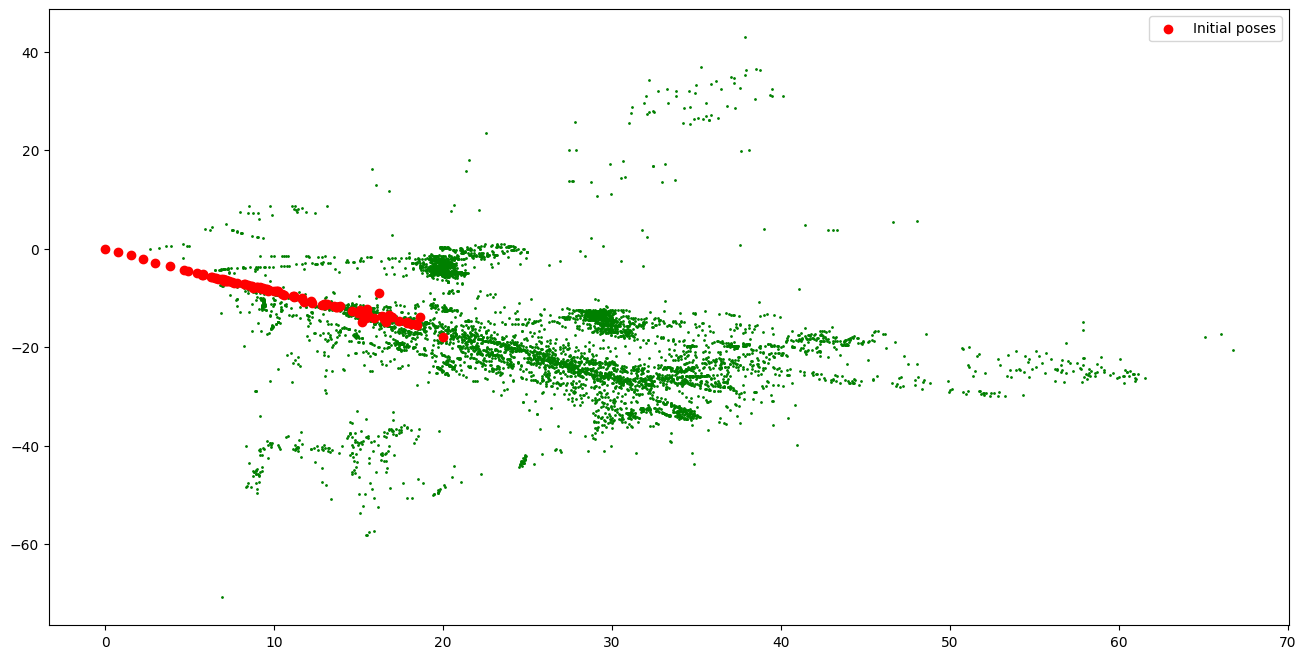

In [132]:
initial_poses = []
final_poses = []
for cam_sym in camera_ids:
  pose_initial = initial_values.atPose3(cam_sym)
  initial_poses.append((pose_initial.translation()[2], -pose_initial.translation()[0])) # OSS: z, -x in camera coordinates becomes x,y in world coordinates if the orientation of the camera is z = forward, x = right, y = downwards
initial_poses = np.array(initial_poses)

points = []
for point_sym in points_ids:
    point = initial_values.atPoint3(point_sym)
    points.append((point[2], -point[0]))
points = np.array(points)

# here we are plotting the original camera poses (pose_initial) and 3D points (point) before we optimize
plt.figure(figsize=(16,8))
plt.scatter(points[:, 0], points[:, 1], c='green', s=1)
plt.scatter(initial_poses[:, 0], initial_poses[:, 1], c='red', label='Initial poses')
plt.legend()

In [133]:
# Optimize
params = gtsam.LevenbergMarquardtParams()
params.setVerbosity("TERMINATION")   # "SILENT", "SUMMARY", "TERMINATION"
params.setVerbosityLM("TERMINATION")   # "SILENT", "SUMMARY", "TERMINATION"
params.setMaxIterations(100)
optimizer = gtsam.LevenbergMarquardtOptimizer(graph, initial_values, params) # see theory
result = optimizer.optimize()
optimizer.print()

converged
errorThreshold: 2927587.79522 <? 0
absoluteDecrease: 0 <? 1e-05
relativeDecrease: 0 <? 1e-05
iterations: 30 >? 100
LevenbergMarquardtOptimizer
  parameters:

relative decrease threshold: 1e-05
absolute decrease threshold: 1e-05
      total error threshold: 0
         maximum iterations: 100
                  verbosity: TERMINATION
         linear solver type: MULTIFRONTAL CHOLESKY
                   ordering: COLAMD
              lambdaInitial: 1e-05
               lambdaFactor: 10
           lambdaUpperBound: 100000
           lambdaLowerBound: 0
           minModelFidelity: 0.001
            diagonalDamping: 0
                minDiagonal: 1e-06
                maxDiagonal: 1e+32
                verbosityLM: TERMINATION


In [136]:
# Calculate average reprojection error (RMSE)
final_error = graph.error(result)
num_factors = graph.size()
rmse = np.sqrt(final_error / num_factors)

print(f"Final Total Error: {final_error:.2f}")
print(f"Number of factors: {num_factors}")
print(f"Average Error (RMSE): {rmse:.4f} (unitless/pixels)")

Final Total Error: 2927587.80
Number of factors: 238563
Average Error (RMSE): 3.5031 (unitless/pixels)


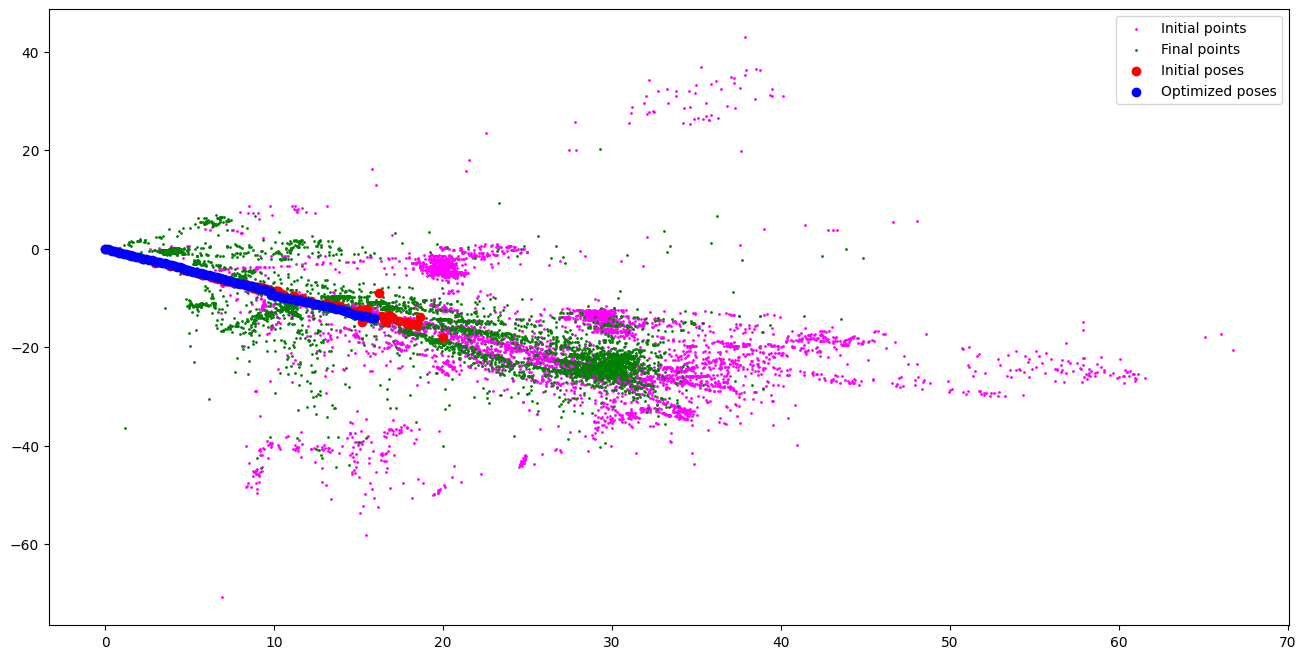

In [134]:
# Keep same scale factor of initial poses
scale = np.linalg.norm(initial_values.atPose3(camera_ids[-1]).translation()) / np.linalg.norm(result.atPose3(camera_ids[-1]).translation())
# explanation: the norm of the position of the last camera is the overall distance covered in a straight line, 
# we can compute the common scale scale factor as the ratio between the distance covered in the first experiement and the 
# distance covered in the result after optimization 

initial_poses = []
final_poses = []
for cam_sym in camera_ids:
  pose_initial = initial_values.atPose3(cam_sym)
  initial_poses.append((pose_initial.translation()[2], -pose_initial.translation()[0])) # same reason as before

  pose_final = result.atPose3(cam_sym)
  final_poses.append((scale*pose_final.translation()[2], -scale*pose_final.translation()[0]))

initial_poses = np.array(initial_poses)
final_poses = np.array(final_poses)


initial_points = []
points = []
for point_sym in points_ids:
    point_initial = initial_values.atPoint3(point_sym)
    point_final = result.atPoint3(point_sym)
    if np.linalg.norm(point_final) > 50/scale or point_final[2] < 0:
      continue
    initial_points.append((point_initial[2], -point_initial[0]))
    points.append((scale*point_final[2], -scale*point_final[0]))
initial_points = np.array(initial_points)
points = np.array(points)

plt.figure(figsize=(16,8))
plt.scatter(initial_points[:, 0], initial_points[:, 1], c='magenta', s=1, label='Initial points')
plt.scatter(points[:, 0], points[:, 1], c='green', s=1, label='Final points')
plt.scatter(initial_poses[:, 0], initial_poses[:, 1], c='red', label='Initial poses')
plt.scatter(final_poses[:, 0], final_poses[:, 1], c='blue', label='Optimized poses')
plt.legend()


In [135]:
# ts does not work

# def gtsam_result_to_open3d(result, pose_keys_prefix='c', point_keys_prefix='p'):
#     geometries = []

#     # --- Collect 3D points ---
#     pts = []
#     for key in result.keys():
#         ch = chr(gtsam.Symbol(key).chr())
#         if ch == point_keys_prefix:
#             pt = result.atPoint3(key)
#             if np.linalg.norm(pt) > 100/scale or pt[2] < 0:
#                 continue
#             pts.append([pt[0]*scale, pt[1]*scale, pt[2]*scale])
#     if pts:
#         pts_np = np.array(pts)
#         pcd = o3d.geometry.PointCloud()
#         pcd.points = o3d.utility.Vector3dVector(pts_np)
#         pcd.paint_uniform_color([0.1, 0.7, 0.1])  # green points
#         geometries.append(pcd)

#     # --- Collect camera poses as coordinate frames ---
#     for key in result.keys():
#         ch = chr(gtsam.Symbol(key).chr())
#         if ch == pose_keys_prefix:
#             pose = result.atPose3(key)
#             T = pose.matrix()
#             T[0:3, 3] *= scale
#             frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.5)
#             frame.transform(T)   # apply pose transform
#             geometries.append(frame)

#     return geometries
# geometries = gtsam_result_to_open3d(result)
# o3d.visualization.draw_geometries(geometries, )
